# Case study: zeroth-order optimization for LLM

In this section, we provide a case study on how new optimization techniques could help us designing novel algorithms for efficient training of LLMs. The main references are {cite}`malladi2023fine,zhang2024revisiting`

Imagine that we want to fine-tune an LLM for some specific task, with only limit computation resources such as one or two A100 GPUs. Usually it should be ok to load the model into the memory and conduct some forward passes. However when we want to train the model, the memory consumption will increase drastically. For example, we just need to load the model weight in to the memory for forward pass, but we will need to compute the gradient (and store it) and compute the EMAs $\hat{\vm}$ and $\hat{\vv}$ for training.

In the following code, we estimate how much memory it takes to train a LeNet for the MNIST handwritten dataset (optimizer states refer to the EMAs $\hat{\vm}$ and $\hat{\vv}$).

Using device: cpu

Memory components (MB):
params: 0.169 MB
grads: 0.169 MB
activations: 2.292 MB
data: 0.384 MB
opt_state: 0.339 MB


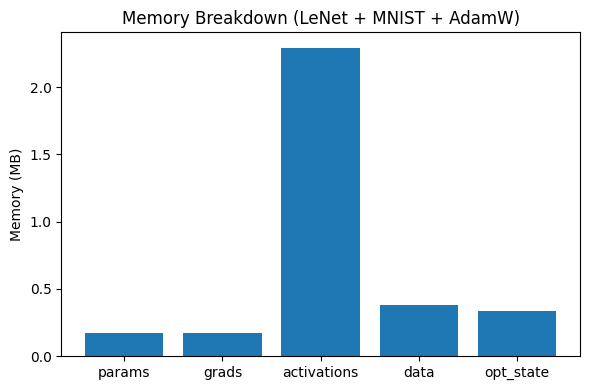

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# ---------------- LeNet for MNIST ----------------
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.avg_pool2d(F.relu(self.conv1(x)), 2)
        x = F.avg_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def bytes_to_mb(x):
    return x / 1024**2

# ----------- This will NEVER crash -----------
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Using device:", device)

batch_size = 128

# ---------------- Data ----------------
transform = transforms.ToTensor()
dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
data, target = next(iter(loader))
data, target = data.to(device), target.to(device)

model = LeNet().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

# ---------------- Activation hooks ----------------
activation_bytes_list = []

def activation_hook(module, inp, out):
    def tensor_bytes(t):
        if isinstance(t, torch.Tensor):
            return t.numel() * t.element_size()
        if isinstance(t, (tuple, list)):
            return sum(tensor_bytes(x) for x in t)
        return 0
    activation_bytes_list.append(tensor_bytes(out))

hooks = []
for m in model.modules():
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        hooks.append(m.register_forward_hook(activation_hook))

# ---- Warmup step (allocates AdamW exp_avg, exp_avg_sq) ----
model.train()
optimizer.zero_grad(set_to_none=True)
out = model(data)
loss = F.cross_entropy(out, target)
loss.backward()
optimizer.step()
optimizer.zero_grad(set_to_none=True)

# Clear warmup activations
activation_bytes_list.clear()

# ---------- Actual forward + backward ----------
out = model(data)
loss = F.cross_entropy(out, target)
loss.backward()

# Remove hooks
for h in hooks:
    h.remove()

# ---------- Memory breakdown ----------
param_bytes = sum(p.numel() * p.element_size() for p in model.parameters())
grad_bytes = sum(p.grad.numel() * p.grad.element_size() for p in model.parameters())
data_bytes = data.numel() * data.element_size() + target.numel() * target.element_size()
activation_bytes = sum(activation_bytes_list)

opt_state_bytes = 0
for state in optimizer.state.values():
    for v in state.values():
        if isinstance(v, torch.Tensor):
            opt_state_bytes += v.numel() * v.element_size()

components = {
    "params": bytes_to_mb(param_bytes),
    "grads": bytes_to_mb(grad_bytes),
    "activations": bytes_to_mb(activation_bytes),
    "data": bytes_to_mb(data_bytes),
    "opt_state": bytes_to_mb(opt_state_bytes),
}

print("\nMemory components (MB):")
for k, v in components.items():
    print(f"{k}: {v:.3f} MB")

# ---------- Plot breakdown ----------
plt.figure(figsize=(6,4))
plt.bar(components.keys(), components.values())
plt.ylabel("Memory (MB)")
plt.title("Memory Breakdown (LeNet + MNIST + AdamW)")
plt.tight_layout()
plt.show()

Note that we can save the activation memory by [activation checkpointing](https://pytorch.org/blog/activation-checkpointing-techniques/), but the optimizer states and gradients are usually loaded in the GPU memory to ensure high speed computing. Therefore, backward can consume more than double of the memory of forward process.

Given our computation resource limit, it would be great if we can conduct mdoel training without the backward process. One such backpropagate-free method is the zeroth-order (ZO) optimziation method. The idea of zeroth-order method is strightforward: using function value differences to approximate the gradients
```{math}
\hat{\nabla}\ell(\vw) = \frac{\ell(\vw + \mu \vu) - \ell(\vw - \mu \vu)}{2\mu}  \vu
```
Here $\vu$ is a random Gaussian vector and $\mu$ is a very small number (such as $10^{-6}$). This way, we only need to do two forward passes to approximately compute for the gradient.

How good is this estimator $\hat{\nabla}\ell(\vw)$ to the true gradient ${\nabla}\ell(\vw)$? Here we have a useful lemma from {cite}`balasubramanian2022zeroth`:

````{prf:lemma} Approximation of ZO gradient to the true gradient
:label: lemma:zo-approx

Under {prf:ref}`assm:smooth`, {prf:ref}`assm:stochastic`, we have

```{math}
\|\mathbb{E}_{\vu}\hat{\nabla}\ell(\vw) - {\nabla}\ell(\vw)\| \leq \frac{\mu}{2}L (d+3)^{3/2}
```
where $d$ is the dimension of the weight $\vw$.

````

From this lemma we know that the zeroth order approximation is pretty good if we take $\mu$ to be sufficiently small.

Now plug $\hat{\nabla}\ell(\vw)$ into AdamW ({prf:ref}`alg:adamw_again`), what we get would be zeroth-order AdamW. Similarly we could get zeroth-order SGD, zeroth-order RMSProp, etc.

These methods could significantly reduce the memory require for LLM training. See the figure below (from {cite}`zhang2024revisiting`) for the memory required for each method to train a 13B model, where "FO" stands for standard first-order methods.

![Memory required for each method to train a 13B model](zo-memory.png "Memory required for each method to train a 13B model")

There are more benefits for zeroth-order training, such as insensitivity to the context length of the input. We refer to {cite}`zhang2024revisiting` for more details.